In [2]:
from data.local_datasets import build_dataset, TS_ASR_Dataset, TS_ASR_Random_Dataset, DataCollator, get_text_norm, TS_ASR_HEAT_Dataset, LhotseLongFormDataset
import lhotse
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from tqdm import tqdm
from txt_norm import get_text_norm
from transformers.models.whisper import WhisperFeatureExtractor
from tqdm import tqdm
from collections import namedtuple
from typing import List, Tuple
from lhotse import SupervisionSegment

In [3]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [4]:
data_args = {
    'train_cutsets': ['/export/fs06/xhe69/TS-ASR-Whisper/data/manifests/ami-sdm_train_sc_cutset_30s.jsonl.gz'],
    # 'train_cutsets': ['/export/fs06/xhe69/TS-ASR-Whisper/data/manifests/ami-sdm_train_sc_cutset.jsonl.gz'],
    # 'dev_cutsets': ['/export/fs06/xhe69/TS-ASR-Whisper/data/manifests/ami-sdm_dev_sc_cutset.jsonl.gz'],
    'eval_cutsets': ['/export/fs06/xhe69/TS-ASR-Whisper/data/manifests/ami-sdm_test_sc_cutset.jsonl.gz'],
    # 'eval_diar_cutsets': ['/export/fs06/xhe69/TS-ASR-Whisper/diar_exp/diarizen_large/diarized_cutsets/ami-sdm_test_sc_cutset.jsonl.gz'],
    'eval_diar_cutsets': ['/export/fs06/xhe69/TS-ASR-Whisper/diar_exp/diarizen_large_twostream_sorthybridloss_e16/diarized_cutsets/ami-sdm_test_sc_cutset.jsonl.gz'],
    'dev_cutsets':['/export/fs06/xhe69/TS-ASR-Whisper/data/manifests/ami-sdm_test_sc_cutset.jsonl.gz'],
    # 'dev_diar_cutsets':['/export/fs06/xhe69/TS-ASR-Whisper/diar_exp/diarizen_large/diarized_cutsets/ami-sdm_test_sc_cutset.jsonl.gz'],
    'dev_diar_cutsets':['/export/fs06/xhe69/TS-ASR-Whisper/diar_exp/diarizen_large_twostream_sorthybridloss_e16/diarized_cutsets/ami-sdm_test_sc_cutset.jsonl.gz'],
    'do_augment': False,
    'dataset_weights': None,
    'use_timestamps': True,
    'musan_noises': None,
    'train_text_norm': "whisper_nsf",
    'empty_transcripts_ratio': 0.0,
    'train_with_diar_outputs': None,
    'audio_path_prefix': None,
    'audio_path_prefix_replacement': None,
    'vad_from_alignments': False,
    'random_sentence_l_crop_p': 0.0,
    'random_sentence_r_crop_p': 0.0,
    'max_l_crop': 0,
    'max_r_crop': 0,
    'cache_features_for_dev': False,
    'eval_text_norm': 'whisper_nsf',
    'use_heat_diar': True,
    'oracle_heat_assignment_method': 'standard',
    'num_heat_channels': 2,
    'diar_type': 'twostream',
}

data_args = dotdict(data_args)


In [4]:
train_cutsets = [lhotse.load_manifest(cutset) for cutset in data_args.train_cutsets]

In [5]:
train_dataset_orig = TS_ASR_Dataset(train_cutsets, do_augment=data_args.do_augment,
                                        dataset_weights=data_args.dataset_weights,
                                        use_timestamps=data_args.use_timestamps,
                                        musan_noises=data_args.musan_noises,
                                        text_norm=get_text_norm(data_args.train_text_norm),
                                        empty_transcript_ratio=data_args.empty_transcripts_ratio,
                                        train_with_diar_outputs=data_args.train_with_diar_outputs,
                                        audio_path_prefix=data_args.audio_path_prefix,
                                        audio_path_prefix_replacement=data_args.audio_path_prefix_replacement,
                                        vad_from_alignments=data_args.vad_from_alignments,
                                        random_sentence_l_crop_p=data_args.random_sentence_l_crop_p,
                                        random_sentence_r_crop_p=data_args.random_sentence_r_crop_p,
                                        max_l_crop=data_args.max_l_crop,
                                        max_r_crop=data_args.max_r_crop,
                                        )

In [6]:
train_dataset = TS_ASR_HEAT_Dataset(train_cutsets, do_augment=data_args.do_augment,
                                        dataset_weights=data_args.dataset_weights,
                                        use_timestamps=data_args.use_timestamps,
                                        musan_noises=data_args.musan_noises,
                                        text_norm=get_text_norm(data_args.train_text_norm),
                                        empty_transcript_ratio=data_args.empty_transcripts_ratio,
                                        train_with_diar_outputs=data_args.train_with_diar_outputs,
                                        audio_path_prefix=data_args.audio_path_prefix,
                                        audio_path_prefix_replacement=data_args.audio_path_prefix_replacement,
                                        vad_from_alignments=data_args.vad_from_alignments,
                                        random_sentence_l_crop_p=data_args.random_sentence_l_crop_p,
                                        random_sentence_r_crop_p=data_args.random_sentence_r_crop_p,
                                        max_l_crop=data_args.max_l_crop,
                                        max_r_crop=data_args.max_r_crop,
                                        oracle_heat_assignment_method=data_args.oracle_heat_assignment_method,
                                        )

In [5]:
def plot_diarization(diarization_array, frame_rate=1, speaker_labels=None, title="Speaker Diarization"):
    """
    Visualize diarization output as a heatmap.

    Parameters:
    - diarization_array: np.ndarray of shape (num_speakers, num_frames)
    - frame_rate: int or float, number of frames per second (for x-axis time labeling)
    - speaker_labels: list of str, custom labels for speakers (optional)
    - title: str, plot title
    """
    num_speakers, num_frames = diarization_array.shape

    plt.figure(figsize=(15, num_speakers * 0.5 + 1))
    plt.imshow(diarization_array, aspect='auto', interpolation='none', cmap='Greys')
    plt.colorbar(label="Activity (1=active, 0=inactive)")

    # X-axis: time in seconds
    x_ticks = np.linspace(0, num_frames - 1, 10, dtype=int)
    x_labels = (x_ticks / frame_rate).round(2)
    plt.xticks(ticks=x_ticks, labels=x_labels)
    plt.xlabel("Time (s)")

    # Y-axis: speakers
    if speaker_labels is None:
        speaker_labels = [f"Speaker {i}" for i in range(num_speakers)]
    plt.yticks(ticks=np.arange(num_speakers), labels=speaker_labels)

    plt.title(title)
    # plt.ylabel("Speakers")
    plt.tight_layout()
    plt.show()

IN1014-36-2-7-0


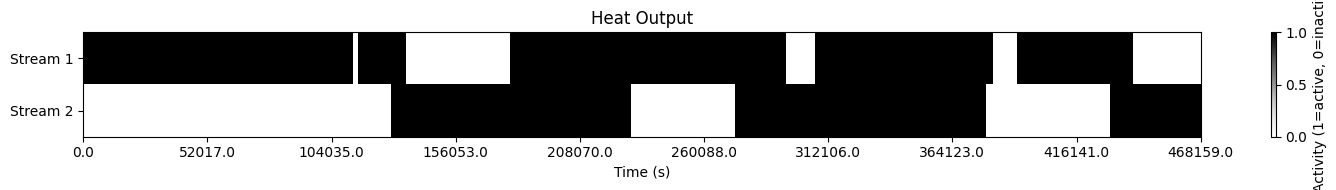

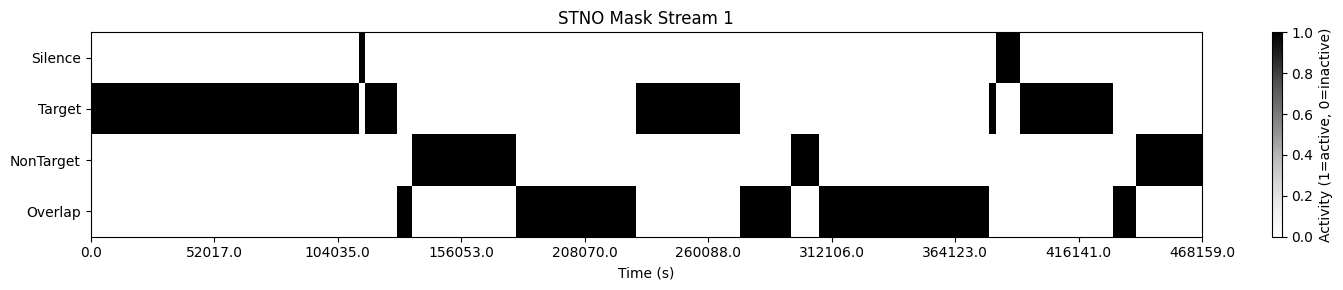

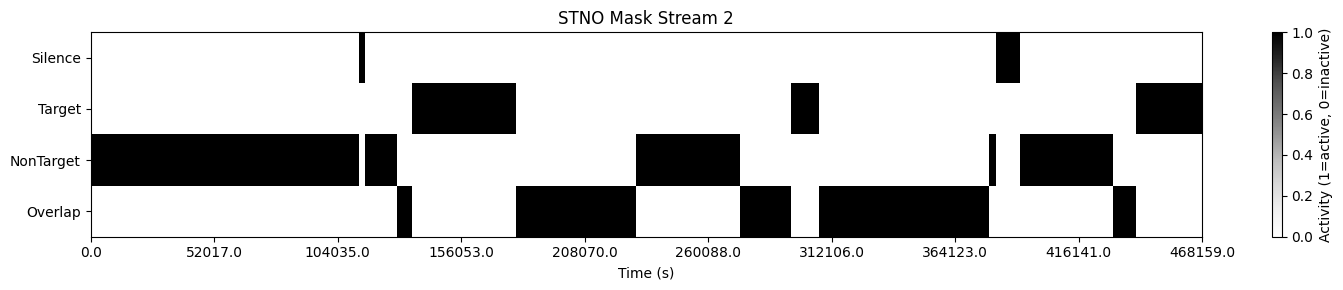

<|0.00|>which is i would like to che say cheap meeting room or i do not know<|7.06|><|7.20|>it is ok it should<|8.44|><|11.18|>but for the moment just for the purpose well f for the moment it is just to understand each other so we know we know that the<|18.40|><|19.14|>pas alexandre pas<|23.82|><|24.44|>ok p a s the third one is<|27.48|>

<|8.04|>well cheap meeting room is the you know it is a conference<|13.24|><|11.20|>ok<|14.34|><|12.00|>you can say then you<|14.22|><|13.24|>room or<|13.68|><|17.08|>it i th i thought it was called pas so i think just use this<|21.04|><|20.18|>for with pas it is ok good idea<|23.64|><|21.92|>p a s<|23.12|><|22.98|>pas<|23.62|><|26.88|>this sounds like alexandre pas<|29.26|>

[[SupervisionSegment(id='IN1014-630-0', recording_id='IN1014', start=0.0, duration=0.26, channel=[0], text='which', language='English', speaker='MIO020', gender='M', custom={'end_': 7.06, 'text_': "which is uh i would like to che say uh cheap uh meeting room or i don't know"}, al

In [8]:
plot_idx = 5936 #should be even, 5842 is example of 3 overlap, 5936 is example of 4 overlap
#186 good plot
print(train_dataset[plot_idx]['cut_id'])
plot_diarization(train_dataset[plot_idx]['heat_mask'], title='Heat Output', speaker_labels=['Stream 1', 'Stream 2'])
plot_diarization(train_dataset[plot_idx]['vad_mask'], title='STNO Mask Stream 1', speaker_labels=['Silence', 'Target', 'NonTarget', 'Overlap'])
plot_diarization(train_dataset[plot_idx+1]['vad_mask'], title='STNO Mask Stream 2', speaker_labels=['Silence', 'Target', 'NonTarget', 'Overlap'])

# print(train_dataset[plot_idx]['all_supervisions'])
# print()
# print(train_dataset[plot_idx]['heat_assignment'][0])
# print()
# print(train_dataset[plot_idx]['heat_assignment'][1])
# print()
print(train_dataset[plot_idx]['transcript'])
print()
print(train_dataset[plot_idx+1]['transcript'])
print()
print(train_dataset[plot_idx]['heat_assignment'])
# print(f'Transcript 1: {train_dataset[plot_idx]['transcript']}')
# print(f'Transcript 2: {train_dataset[plot_idx+1]['transcript']}')


In [6]:
from collections import defaultdict
from copy import deepcopy
from typing import List, Dict, Tuple, Any

# ---------- helpers ----------

def _seg_end(seg):
    if hasattr(seg, 'end_'):
        return getattr(seg, 'end_')
    if hasattr(seg, 'custom') and isinstance(seg.custom, dict) and 'end_' in seg.custom:
        return seg.custom['end_']
    return seg.start + getattr(seg, 'duration', 0.0)

def _by_speaker(segments) -> Dict[str, List[Any]]:
    by_spk = defaultdict(list)
    for s in segments:
        by_spk[getattr(s, 'speaker', 'UNK')].append(s)
    # Ensure time order per speaker
    for spk in by_spk:
        by_spk[spk].sort(key=lambda x: (x.start, _seg_end(x)))
    return by_spk

# ---------- step 2: combine by beta while keeping words ----------

class Utterance:
    __slots__ = ("speaker", "start", "end", "words")
    def __init__(self, speaker: str, start: float, end: float, words: List[Any]):
        self.speaker = speaker
        self.start = start
        self.end = end
        self.words = words  # list of original word segments (kept intact)

def combine_by_beta(words_for_spk: List[Any], beta: float) -> List[Utterance]:
    """Combine consecutive words into utterances if the GAP between consecutive words is <= beta."""
    if not words_for_spk:
        return []
    utts: List[Utterance] = []
    cur_words = [words_for_spk[0]]
    cur_start = words_for_spk[0].start
    cur_end = _seg_end(words_for_spk[0])
    spk = getattr(words_for_spk[0], 'speaker', 'UNK')

    for w in words_for_spk[1:]:
        w_start, w_end = w.start, _seg_end(w)
        gap = max(0.0, w_start - cur_end)
        if gap <= beta:
            cur_words.append(w)
            cur_end = max(cur_end, w_end)
        else:
            utts.append(Utterance(spk, cur_start, cur_end, cur_words))
            cur_words = [w]
            cur_start, cur_end = w_start, w_end
    utts.append(Utterance(spk, cur_start, cur_end, cur_words))
    return utts

def build_utterances_by_speaker(segments: List[Any], beta: float) -> Dict[str, List[Utterance]]:
    by_spk = _by_speaker(segments)
    return {spk: combine_by_beta(ws, beta) for spk, ws in by_spk.items()}

# ---------- step 3/3a: interleave words with alpha rule ----------

def _has_overlapping_candidate(other_words: List[Any], t_end: float) -> bool:
    """Return True if the other speaker's next word starts before the current word's end."""
    if not other_words:
        return False
    next_w = other_words[0]
    return next_w.start < t_end  # overlap if it begins before current finishes

def interleave_with_alpha(utts_by_spk: Dict[str, List[Utterance]], alpha: float, beta: float) -> List[Any]:
    """
    Iterate word-by-word across speakers:
      - keep placing words from the current speaker,
      - but if current speaker's block has lasted >= alpha and there exists an overlapping word
        from another speaker, switch to that other speaker.
    Returns a reordered list of the ORIGINAL word segments.
    """
    # Prepare per-speaker queues of WORDS (flatten utterances back to words keeping order)
    words_queues: Dict[str, List[Any]] = {
        spk: [w for utt in utts for w in utt.words]
        for spk, utts in utts_by_spk.items()
    }

    # Prime global time ordering to pick the very first word
    def _peek_earliest():
        best = None
        for spk, q in words_queues.items():
            if not q:
                continue
            cand = q[0]
            if best is None or (cand.start, _seg_end(cand)) < (best.start, _seg_end(best)):
                best = cand
        return best

    output_words: List[Any] = []
    current_spk = None
    block_start_time = None
    last_word_end = None

    while True:
        # done?
        if all(len(q) == 0 for q in words_queues.values()):
            break

        # choose next word
        if current_spk is None:
            # pick earliest across all speakers
            nxt = _peek_earliest()
            if nxt is None:
                break
            current_spk = getattr(nxt, 'speaker', 'UNK')
            block_start_time = nxt.start
            # pop from that speaker
            word = words_queues[current_spk].pop(0)
            output_words.append(word)
            last_word_end = _seg_end(word)
            continue

        # try to continue with current speaker
        cur_q = words_queues.get(current_spk, [])
        # if current speaker queue empty, switch to earliest other
        if not cur_q:
            nxt = _peek_earliest()
            if nxt is None:
                break
            current_spk = getattr(nxt, 'speaker', 'UNK')
            block_start_time = nxt.start
            word = words_queues[current_spk].pop(0)
            output_words.append(word)
            last_word_end = _seg_end(word)
            continue

        # candidate from current speaker
        cur_word = cur_q[0]
        # starvation check: has current block lasted >= alpha?
        block_elapsed = (last_word_end if last_word_end is not None else cur_word.start) - block_start_time
        starvation = block_elapsed >= alpha

        # check overlapping other-speaker option
        switchable_spk = None
        if starvation:
            for spk, q in words_queues.items():
                if spk == current_spk or not q:
                    continue
                if _has_overlapping_candidate(q, _seg_end(cur_word)):
                    switchable_spk = spk
                    break

        if switchable_spk is not None:
            # switch to other speaker (starvation relief)
            word = words_queues[switchable_spk].pop(0)
            output_words.append(word)
            current_spk = switchable_spk
            block_start_time = word.start
            last_word_end = _seg_end(word)
        else:
            # Cohesion: if gap from last_word_end to cur_word.start is small (<= beta), keep current speaker;
            # Otherwise, if another speaker has an earlier word, switch.
            gap = 0.0 if last_word_end is None else max(0.0, cur_word.start - last_word_end)

            if gap <= beta:
                word = words_queues[current_spk].pop(0)
                output_words.append(word)
                last_word_end = _seg_end(word)
            else:
                # pick globally earliest next word (could be another speaker)
                nxt = _peek_earliest()
                if nxt is None:
                    # no other words; emit current
                    word = words_queues[current_spk].pop(0)
                    output_words.append(word)
                    last_word_end = _seg_end(word)
                else:
                    nxt_spk = getattr(nxt, 'speaker', 'UNK')
                    if nxt_spk != current_spk and nxt.start < cur_word.start:
                        # switch because other speaker's next word is earlier in time
                        word = words_queues[nxt_spk].pop(0)
                        output_words.append(word)
                        current_spk = nxt_spk
                        block_start_time = word.start
                        last_word_end = _seg_end(word)
                    else:
                        # stay with current speaker
                        word = words_queues[current_spk].pop(0)
                        output_words.append(word)
                        last_word_end = _seg_end(word)

    return output_words

# ---------- main entry ----------

def reorder_transcripts_with_alpha_beta(segments: List[Any], alpha: float, beta: float) -> List[Any]:
    """
    Full pipeline:
      1) group by speaker
      2) combine into utterances by beta (gap threshold), preserving word timestamps
      3) interleave words across speakers with alpha-based starvation breaking
    Returns the reordered list of ORIGINAL word segments.
    """
    segs = deepcopy(segments)  # don't mutate caller's objects
    # Ensure global sort (defensive)
    segs.sort(key=lambda s: (s.start, _seg_end(s)))
    utts_by_spk = build_utterances_by_speaker(segs, beta=beta)
    return interleave_with_alpha(utts_by_spk, alpha=alpha, beta=beta)


In [80]:
def new_merge(transcript_segments):
    new_merged_list = []

    
    for supervision in transcript_segments:
        if len(new_merged_list) == 0:
            supervision.end_ = supervision.end
            supervision.text_ = supervision.text
            new_merged_list.append(supervision)
        elif new_merged_list[-1].speaker != supervision.speaker:
            supervision.end_ = supervision.end
            supervision.text_ = supervision.text
            new_merged_list.append(supervision)
        else:
            if round(new_merged_list[-1].end_, 2) == round(supervision.start, 2) or supervision.start - \
                    new_merged_list[-1].end_ <= 0.0:
                new_merged_list[-1].end_ = supervision.end
                new_merged_list[-1].text_ = new_merged_list[-1].text_ + " " + supervision.text
            else:
                supervision.end_ = supervision.end
                supervision.text_ = supervision.text
                new_merged_list.append(supervision)
    return new_merged_list

In [81]:
old_transcript = [sup for supseg in train_dataset[plot_idx]['heat_assignment'][1] for sup in supseg.alignment]
# print(old_transcript)
new_transcripts = reorder_transcripts_with_alpha_beta(old_transcript, alpha=5.0, beta=0.5)
new_merge(new_transcripts)

# <|8.04|>well cheap meeting room is the you know it is a conference room or<|13.68|><|11.20|>ok<|14.34|><|12.00|>you can say then you<|14.22|><|17.08|>it i th i thought it was called pas so i think just use this<|21.04|><|20.18|>for with pas it is ok good idea<|23.64|><|21.92|>p a s<|23.12|><|21.92|>p a s<|23.12|><|26.88|>this sounds like alexandre pas<|29.26|>


[SupervisionSegment(id='IN1014-305-0', recording_id='IN1014', start=8.05, duration=0.32, channel=[0], text='well', language='English', speaker='MIO016', gender='M', custom={'end_': 13.24, 'text_': "well cheap meeting room is the you know mm it's a conference"}, alignment=None),
 SupervisionSegment(id='IN1014-631-0', recording_id='IN1014', start=11.2, duration=3.14, channel=[0], text='okay', language='English', speaker='MIO020', gender='M', custom={'end_': 14.34, 'text_': 'okay'}, alignment=None),
 SupervisionSegment(id='IN1014-1030-0', recording_id='IN1014', start=12.01, duration=0.12, channel=[0], text='you', language='English', speaker='MIO024', gender='M', custom={'end_': 14.22, 'text_': 'you can say then you'}, alignment=None),
 SupervisionSegment(id='IN1014-305-12', recording_id='IN1014', start=13.24, duration=0.29, channel=[0], text='room', language='English', speaker='MIO016', gender='M', custom={'end_': 13.68, 'text_': 'room or'}, alignment=None),
 SupervisionSegment(id='IN1014

In [12]:
for i in range(len(train_dataset_orig)):
    if train_dataset_orig[i]['cut_id'] == 'ES2015b-0-2-33-13':
        print(i)
        break

231


In [6]:
plot_idx = 231 #should be even, 5842 is example of 3 overlap
#186 good plot
print(train_dataset_orig[plot_idx]['cut_id'])
plot_diarization(train_dataset_orig[plot_idx]['speaker_mask'], title='Diarization Mask', speaker_labels=['Speaker 1', 'Speaker 2', 'Speaker 3'])
plot_diarization(train_dataset_orig[plot_idx]['vad_mask'], title='STNO Mask Stream 1', speaker_labels=['Silence', 'Target', 'NonTarget', 'Overlap'])
plot_diarization(train_dataset_orig[plot_idx+1]['vad_mask'], title='STNO Mask Stream 2', speaker_labels=['Silence', 'Target', 'NonTarget', 'Overlap'])


NameError: name 'train_dataset_orig' is not defined

In [ ]:
overlap_indices = []

# for plot_idx in tqdm(range(0, len(train_dataset), 2)):
#     if 2 in train_dataset[plot_idx]['heat_output'] or 3 in train_dataset[plot_idx]['heat_output']:
#         overlap_indices.append(plot_idx)
#25.74% of ami-sdm samples has of >2 people overlapping but overlapping time is likely low 

In [8]:
dec_args = {
    'soft_vad_temp': None,
}
container = {
    'feature_extractor': WhisperFeatureExtractor.from_pretrained('openai/whisper-large-v3-turbo'),
}
dec_args = dotdict(dec_args)
container = dotdict(container)

text_norm = get_text_norm(data_args.eval_text_norm)

dev_dataset = build_dataset(data_args.eval_cutsets, data_args, dec_args, text_norm, container,
                                data_args.eval_diar_cutsets)

loading configuration file preprocessor_config.json from cache at /home/xhe69/.cache/huggingface/hub/models--openai--whisper-large-v3-turbo/snapshots/41f01f3fe87f28c78e2fbf8b568835947dd65ed9/preprocessor_config.json
Feature extractor WhisperFeatureExtractor {
  "chunk_length": 30,
  "feature_extractor_type": "WhisperFeatureExtractor",
  "feature_size": 128,
  "hop_length": 160,
  "n_fft": 400,
  "n_samples": 480000,
  "nb_max_frames": 3000,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "WhisperProcessor",
  "return_attention_mask": false,
  "sampling_rate": 16000
}

Using LhotseLongFormHeatDataset


In [9]:
dev_dataset.diar_type

'twostream'

ES2004b-7,0


/home/xhe69/.conda/envs/ts_asr_whisper/lib/python3.11/site-packages/matplotlib/image.py:176: UserWarning: Data with more than 2**23 columns cannot be accurately displayed. Downsampling to less than 2**23 columns before displaying. To remove this warning, manually downsample your data.
  warnings.warn(msg.format(n='2**23 columns'))


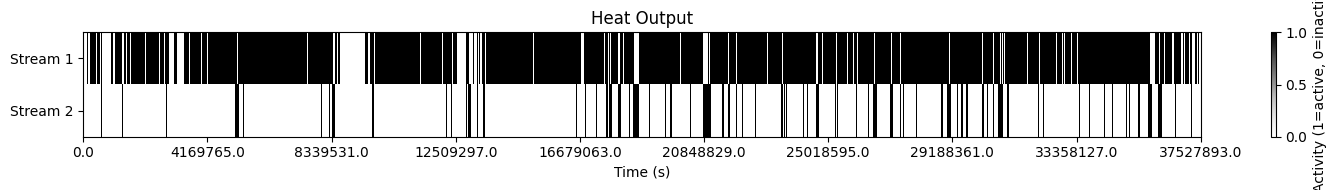

/home/xhe69/.conda/envs/ts_asr_whisper/lib/python3.11/site-packages/matplotlib/image.py:176: UserWarning: Data with more than 2**23 columns cannot be accurately displayed. Downsampling to less than 2**23 columns before displaying. To remove this warning, manually downsample your data.
  warnings.warn(msg.format(n='2**23 columns'))


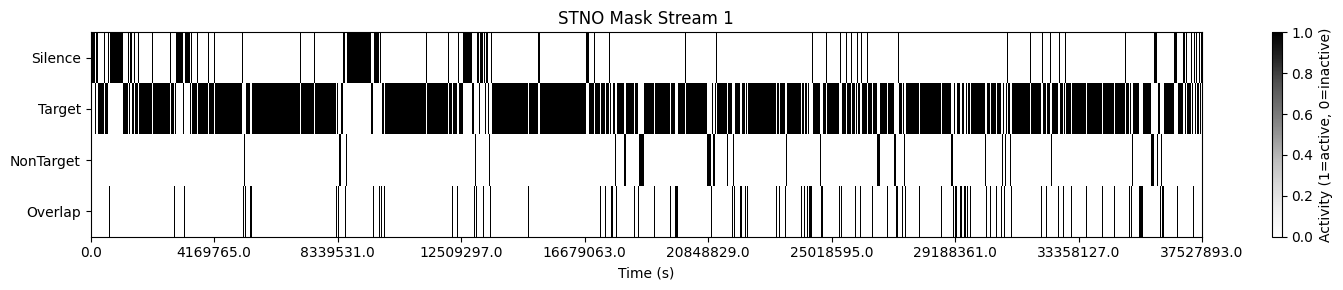

/home/xhe69/.conda/envs/ts_asr_whisper/lib/python3.11/site-packages/matplotlib/image.py:176: UserWarning: Data with more than 2**23 columns cannot be accurately displayed. Downsampling to less than 2**23 columns before displaying. To remove this warning, manually downsample your data.
  warnings.warn(msg.format(n='2**23 columns'))


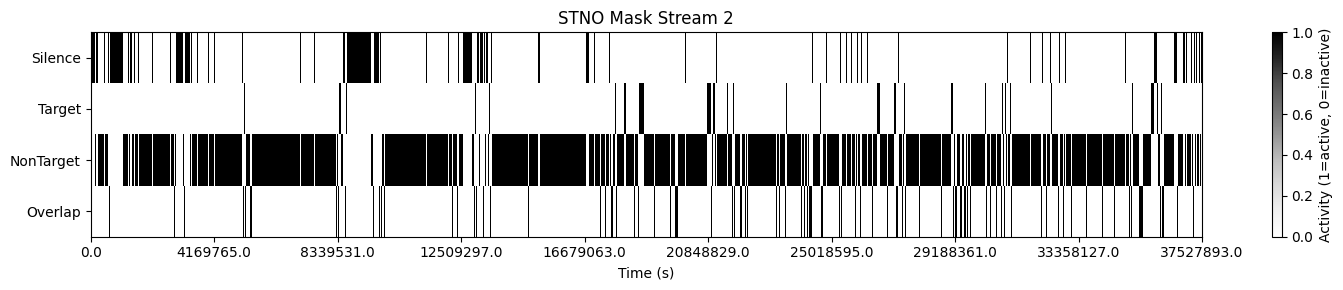

In [10]:
val_idx = 14 #TS3003c-0,MTD0010ID
print(dev_dataset[val_idx]['transcript'])
# plot_diarization(dev_dataset[val_idx]['spk_mask'], title='Diarization')
plot_diarization(dev_dataset[val_idx]['heat_mask'], title='Heat Output', speaker_labels=['Stream 1', 'Stream 2'])
plot_diarization(dev_dataset[val_idx]['vad_mask'], title='STNO Mask Stream 1', speaker_labels=['Silence', 'Target', 'NonTarget', 'Overlap'])
plot_diarization(dev_dataset[val_idx+1]['vad_mask'], title='STNO Mask Stream 2', speaker_labels=['Silence', 'Target', 'NonTarget', 'Overlap'])

In [ ]:
dev_dataset[0]['all_supervisions'][0]

In [ ]:
Event = namedtuple("Event", ["time", "type", "segment_id"])

def compute_supervision_overlaps(supervisions: List[SupervisionSegment]) -> List[Tuple[float, float, int]]:
    """
    Identify overlapping supervision regions and count overlapping speakers.

    Returns:
        List of (start_time, end_time, num_overlapping_speakers)
    """
    events = []
    for seg in supervisions:
        start = seg.start
        end = seg.end_  # duration instead of .end_
        seg_id = seg.id
        events.append(Event(time=start, type='start', segment_id=seg_id))
        events.append(Event(time=end, type='end', segment_id=seg_id))

    # Sort by time, end before start if tied
    events.sort(key=lambda e: (e.time, 0 if e.type == 'end' else 1))

    active_ids = set()
    overlaps = []
    last_time = None

    for event in events:
        current_time = event.time

        if last_time is not None and current_time > last_time:
            if len(active_ids) > 1:
                overlaps.append((last_time, current_time, len(active_ids), active_ids.copy()))

        if event.type == 'start':
            active_ids.add(event.segment_id)
        elif event.type == 'end':
            active_ids.discard(event.segment_id)

        last_time = current_time

    return overlaps

In [ ]:
dev_dataset[4].keys()

In [ ]:
overlap_by_recordingid = {}

for idx in tqdm(range(0, len(dev_dataset), 2)):
    recording_id = dev_dataset[idx]['all_supervisions'][0].recording_id
    # print(f'Recording {recording_id}')
    overlaps = compute_supervision_overlaps(dev_dataset[idx]['all_supervisions'])
    overlap_by_recordingid[recording_id] = overlaps
    for start, end, count, active_ids in overlaps:
        if count > 2:
            print(f"Overlap from {start:.2f}s to {end:.2f}s ({end - start:.2f}s) with {count} speakers {active_ids}")

In [ ]:
# [(i, i[1]-i[0]) for i in overlap_by_recordingid['TS3003d'] if i[2]>2]

In [ ]:
speaker_ids = ['EN2002a', 'EN2002b', 'EN2002c', 'EN2002d', 
               'ES2004a', 'ES2004b', 'ES2004c', 'ES2004d', 
               'IS1009a', 'IS1009b', 'IS1009c', 'IS1009d',
               'TS3003a', 'TS3003b', 'TS3003c', 'TS3003d',
              ]

for speaker_id in speaker_ids:
    total_2plus_overlap_seconds = 0.0
    for overlap in overlap_by_recordingid[speaker_id]:
        start, end, num_speakers, active_ids = overlap
        
        if num_speakers > 2:
            overlap_seconds = (end - start) * (num_speakers - 2)
            total_2plus_overlap_seconds += overlap_seconds
            # print(f"Overlap from {start:.2f}s to {end:.2f}s ({end - start:.2f}s) with {num_speakers} speakers {active_ids}")
    print(speaker_id, total_2plus_overlap_seconds)